In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import dask
from dask.dot import dot_graph
from elfi.core import *
from elfi.distributions import *
from elfi.methods import Rejection
from elfi.examples.ma2 import MA2, autocov, distance
from elfi.wrapper import Wrapper
from distributed import Client
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

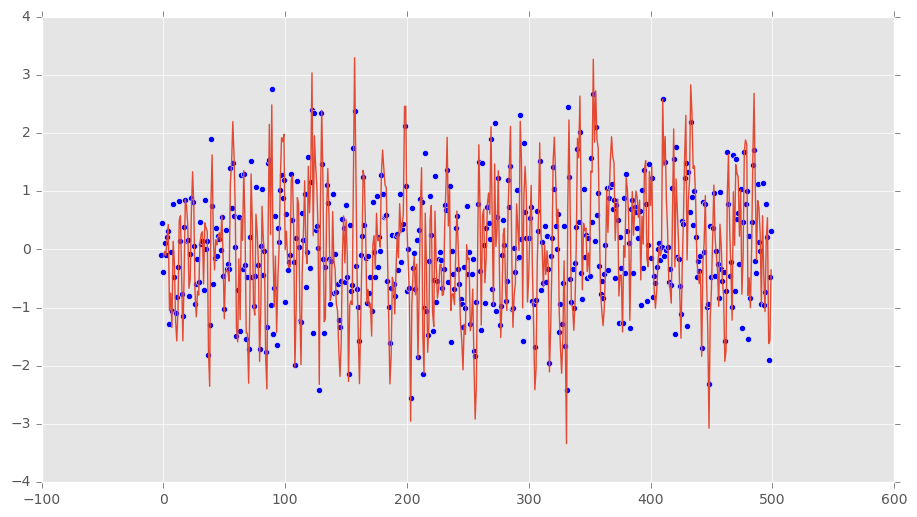

In [2]:
n_obs = 500
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y
latents = np.random.randn(n_obs + 2)
y = MA2(n_obs, t1_0, t2_0, n_sim=1, latents=latents)

# Plot
plt.figure(figsize=(11, 6));
plt.plot(np.arange(0,n_obs),y[0,:]);
plt.scatter(np.arange(-2,n_obs), latents);

In [3]:
# Set up the simulator (assume current dir is elfi/notebooks and ma2.bin compiled)

command = "../examples/cpp/ma2/ma2.bin {1} {2} {seed} {0}"
simulator = partial(Wrapper(command), n_obs)

# Set up autocovariance summaries
ac1 = partial(autocov, 1)
ac2 = partial(autocov, 2)

# Specify the graphical model
t1 = Prior('t1', 'uniform', 0, 1)
t2 = Prior('t2', 'uniform', 0, 1)
Y = SequentialSimulator('MA2', simulator, t1, t2, observed=y)
S1 = Summary('S1', ac1, Y)
S2 = Summary('S2', ac2, Y)
d = Discrepancy('d', distance, S1, S2)

In [4]:
# Specify the number of simulations and set up rejection sampling
n_samples = 200
batch_size = 200
rej = Rejection(n_samples, d, [t1, t2], batch_size)

In [5]:
# Time and run the simulator in parallel
%time result = rej.infer(quantile=0.01)

CPU times: user 13.6 s, sys: 1min 25s, total: 1min 38s
Wall time: 1min 20s


In [6]:
[t1_post, t2_post] = result['samples']
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

Number of accepted samples 200 with threshold 12.23
Posterior means: 0.66 0.17


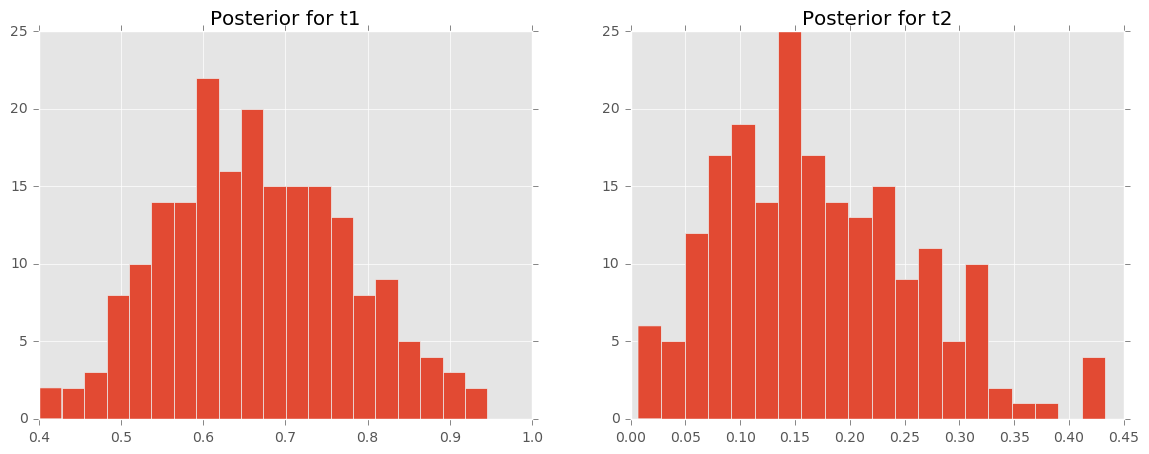

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Posterior for t2");